# <b>About QUORA </b>

- <b>Quora</b> is a social media platform where users can ask questions and answer them, and collaborate by editing questions and commenting on answers. It was founded in 2009 and became available to the public in 2010

<h1> 1. Business Problem </h1>

<h2> 1.1 Problem Statement: </h2>
- Identify which questions asked on Quora are duplicates of questions that have already been asked. <br>
- This could be useful to instantly provide answers to questions that have already been answered. <br>
- We are tasked with predicting whether a pair of questions are duplicates or not. <br>

<h2>1.2 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns. (The Answers can take few hours to respond but the probablity score should be more than 99%)
4. Interpretability is partially important.

<h1> 2. Data Overview <h1>

<h2> 2.1 Importing necessary Libraries <h2>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
# 1. Data Manipulation
import pandas as pd
import numpy as np

#2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#3. Data Preprocessing and transformation
import nltk
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#4. others
import os


<h2> 2.1 Reading data <h2>

In [2]:
# Get the current working directory
abspath = os.getcwd()

# Load the CSV file
df = pd.read_csv(os.path.join(abspath, 'DataSets/train.csv'))


<h2> 2.2 Data Summary <h2>

In [3]:
print('='*70)
print('Columns/Features in the Dataset')
for index, column in enumerate(df.columns):
    print(index + 1, ": ", column)

print('='*70)
print('Total Data Points: ', df.shape[0])

print('='*70)
print('Sample Data: ')
df.sample(3)


Columns/Features in the Dataset
1 :  id
2 :  qid1
3 :  qid2
4 :  question1
5 :  question2
6 :  is_duplicate
Total Data Points:  404290
Sample Data: 


id    qid1    qid2                             question1  \
290440  290440  411735  411736         Newly added country in world?   
314667  314667  439427  439428      How should people live together?   
231396  231396  264362  341195  How do I buy Microsoft MB6-705 Exam?   

                                                question2  is_duplicate  
290440  State the existence theoreme on the solution o...             0  
314667                            How should people live?             0  
231396  Can I get a job in Microsoft if I qualify Micr...             0

<h1> 3. Mapping the real world problem to ML problem  <h1>

<h2> 3.1 Type of Machine Leaning Problem </h2>

<p> It is a binary classification problem, for a given pair of questions (Columns: question1 and question2) we need to predict if they are duplicate or not. </p>

- X -> question1, question2 {descriptive}
- y -> is_duplicate {0,1}

<h2> 3.2 Train Test Split </h2>

1. We will do a random splitting of 80:20 or 70:30
2. we don't have timestamps to split the data (Time-based splitting)
3. Id column can be useful here to split the data as latest ID means recently created (Can be used as Time-based splitting) -- experimentation

<h2> 3.3 Models to be used for predicting </h2>

1. Logistic Regression
2. SVM 
3. Decision Tree
4. XG Boost

<h2> 3.4 Performance Metrics </h2>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h1> 4. Exploratory Data Analysis <h1>

<h2> 4.1 Basic Stats </h2>

In [4]:
print('Data types:')
df.dtypes

Data types:


id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

<h3> 4.1.1 Checking Target Variable Distribution </h2>

In [5]:
df['is_duplicate'].value_counts().index

Index([0, 1], dtype='int64', name='is_duplicate')

In [6]:
print('Total Datapoints: ', df.shape[0])
fig = px.bar(x = ['Not Duplicate', 'Duplicate']
            , y = df['is_duplicate'].value_counts().values
            , template= 'plotly_dark'
            , color= df['is_duplicate'].value_counts().values
        )
fig.update_traces(text = np.round((df['is_duplicate'].value_counts().values/ df.shape[0]) * 100, 2))
fig.update_layout(
        xaxis_title="Duplicate Status"
        , yaxis_title="Count Of Question Pairs"
        , coloraxis_showscale=False
)


Total Datapoints:  404290


Observations:
1. In the dataset we have total <b>404k</b> datapoints.
2. Out of which <b>63%</b> pair of questions are not duplicate and <b>37%</b> are duplicates
3. So we have enough data points for training model

<h3> 4.1.2 Checking Unique and Duplicate Questions</h3>

In [7]:
# converting the series type into list (for lists operation)
question_lists = df['question1'].to_list()
question_lists.extend(df['question2'].to_list())
questions = pd.Series(question_lists)

print('Total Number of questions from both the lists: '
    , len(question_lists))
print('Total Number of Unique questions: '
    , len(list(set(question_lists))))
print("Total Unique questions which appears more than one: "
    , questions.value_counts()[questions.value_counts().values > 1].count())
print("One question with maximum occurrence: "
    , questions.value_counts()[questions.value_counts().values > 1].max())

Total Number of questions from both the lists:  808580
Total Number of Unique questions:  537361
Total Unique questions which appears more than one:  111872
One question with maximum occurrence:  161


In [8]:
fig = px.bar(x = ['Unique Questions', 'Repeated Questions']
            , y = [len(list(set(question_lists))),
                questions.value_counts()[questions.value_counts().values > 1].count()]
            , template= 'plotly_dark'
            , color= ['blue', 'red']
        )
fig.update_layout(
        xaxis_title="Questions"
        , yaxis_title="Count Of Question"
        , coloraxis_showscale=False
)

<b>Observations:</b>
1. We have approximately <b>808K</b> total questions in both the question pairs.
2. Out of which <b>537K</b> are unique questions with <b>111K (20%)</b> repeated questions (more than 1)

<h3> 4.1.3 Distribution of questions</h3>

In [9]:
# Create histogram
fig = px.histogram(questions.value_counts().values, nbins=500 
                   , title='Log Histogram of question appearance'
                    , log_y = True
                    , template = 'plotly_dark'
)

fig.update_layout(
        xaxis_title="Question Occurrences"
        , yaxis_title="Count Of Questions"
        , coloraxis_showscale=False
)
# Show plot
fig.show()

<b>Observations:</b>
1. Most of the questions occurs only once in the dataset
2. And also we have very few questions that has occurred more than 50
3. The graph is more denser below 50

<h3> 4.1.4 Dealing with the NULL values </h3>

In [10]:
# Checking the number of null values in each columns
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [11]:
# we are doing this basic feature engineering to fill the Nan values
df.fillna(' ', inplace = True)
# chekcing the null values again
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<h2> 4.2 Feature Extraction </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [12]:
if os.path.isfile('DataSets/df_feature_extraction.csv'):
    df = pd.read_csv("DataSets/df_feature_extraction.csv",encoding='latin-1')
else:

    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(str(row).split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(str(row).split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("DataSets/df_feature_extraction.csv", index=False)


<h3> 4.2.1 Analysis of some extracted features </h3 

In [13]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


<h4> 4.2.1.1 Feature: word_share </h4>

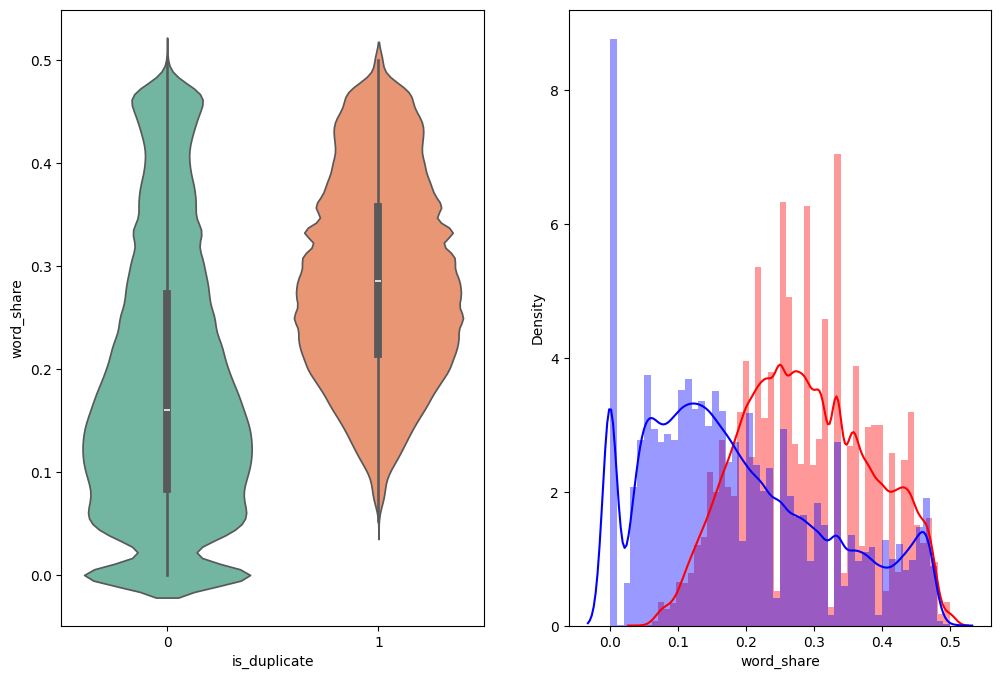

In [14]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:], palette='Set2')

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red', kde = True)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue', kde = True )
plt.show()

<b>Observations</b>:
1. The peak of the feature with respect non-duplicate pairs is at the value 0
2. There is some overlapping for both the classes but the dense decreases when the value is more than 0.2


<h4> 4.2.1.2 Feature: word_Common </h4>

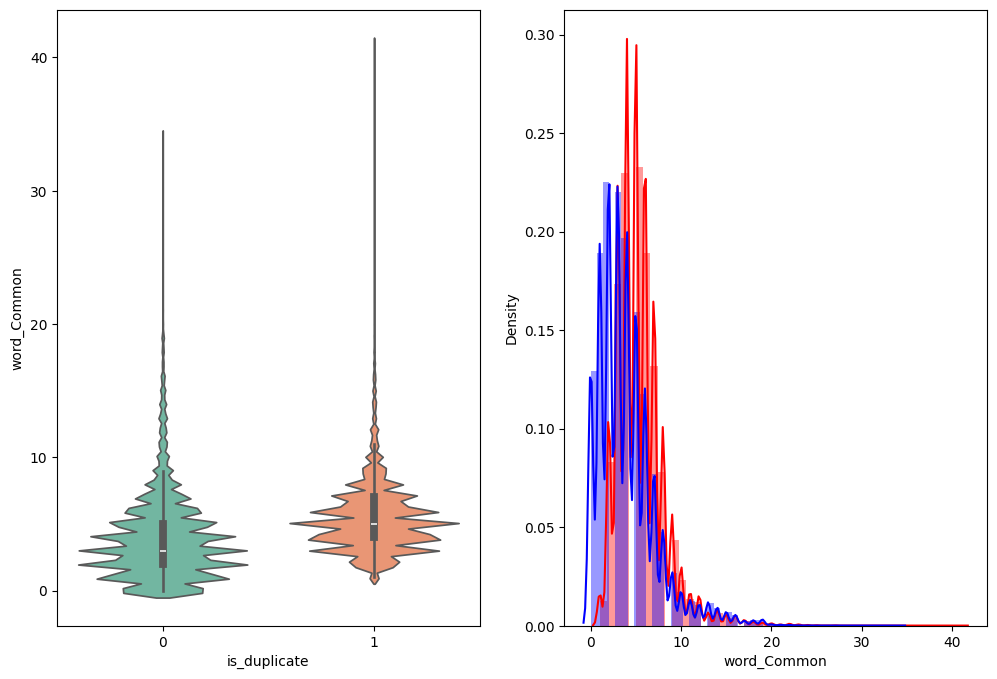

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:], palette='Set2')

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red', kde = True)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<b>Observations</b>:
For both the classes this feature is overallping and not seperable

In [16]:
# Lets Save the first two extracted column in form of dictionary as
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

In [23]:
df[df['qid1'] == 14110].sample()

id   qid1  qid2  \
399718  399718  14110  3121   

                                                question1  \
399718  How does the ban on 500 and 1000 rupee notes h...   

                                                question2  is_duplicate  \
399718  Will banning Rs.500 and Rs.1000 notes help to ...             1   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
399718         48          7     90     79          17          13   

        word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
399718          6.0        28.0    0.214286          55          41

In [43]:
qid1_frequency = pd.DataFrame(df['qid1'].value_counts()).reset_index()
qid1_frequency.columns = ['qid1_n', 'freq_qid1']
qid1_frequency.to_csv('trained_model/qid1_frequency.csv', index=False)


In [42]:
qid2_frequency = pd.DataFrame(df['qid2'].value_counts()).reset_index()
qid2_frequency.columns = ['qid2_n', 'freq_qid2']
qid2_frequency.to_csv('trained_model/qid2_frequency.csv', index=False)

In [41]:
qid1_frequency.head()

qid1  freq_qid1
0   8461         50
1  14110         48
2   1749         47
3  20628         47
4  25984         47

In [ ]:
df.drop(col)